# Survivial Analysis

### Hina Hussain
#### 06 May 2022

# Introduction

The aim of this project is to develop a survival analysis model. The model is based on the mortgages dataset provided.
<br>
<br>
Survival analysis is used for analyzing the expected duration of time until an event occurs. The event in this case is defaulting on the mortgage. The output of this project will be the expected time till a borrower defaults and the different macroeconomic measures that impact the time to default.

In [9]:
import lifelines # pip install lifelines
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

In [4]:
# load dataset
credit_surv = pd.read_csv('../Project//Assignment2022_Data/mortgage.csv')

In [10]:
credit_surv

,id,time,orig_time,first_time,mat_time,balance_time,LTV_time,interest_rate_time,hpi_time,gdp_time,uer_time,REtype_CO_orig_time,REtype_PU_orig_time,REtype_SF_orig_time,investor_orig_time,balance_orig_time,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,hpi_orig_time,default_time,payoff_time,status_time
0,1,25,-7,25,113,41303.42,24.498336,9.200,226.29,2.899137,4.7,0,0,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
1,1,26,-7,25,113,41061.95,24.483867,9.200,225.10,2.151365,4.7,0,0,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
2,1,27,-7,25,113,40804.42,24.626795,9.200,222.39,2.361722,4.4,0,0,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
3,1,28,-7,25,113,40483.89,24.735883,9.200,219.67,1.229172,4.6,0,0,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
4,1,29,-7,25,113,40367.06,24.925476,9.200,217.37,1.692969,4.5,0,0,1,0,45000.0,715,69.4,9.20,87.03,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622484,50000,56,16,52,177,517107.42,57.659403,2.664,181.43,1.717053,6.6,1,0,0,0,664000.0,653,80.0,1.75,167.91,0,0,0
622485,50000,57,16,52,177,512274.57,55.359916,2.652,187.20,2.556052,6.2,1,0,0,0,664000.0,653,80.0,1.75,167.91,0,0,0
622486,50000,58,16,52,177,507396.72,54.492206,2.644,188.37,2.868594,6.2,1,0,0,0,664000.0,653,80.0,1.75,167.91,0,0,0
622487,50000,59,16,52,177,502478.87,54.171106,2.638,187.65,2.443648,5.7,1,0,0,0,664000.0,653,80.0,1.75,167.91,0,0,0


# Data Exploration

The first step is to explore the data available. It is found that the LTV_time variable has some missing observations. Since LTV is based on the loan amount and is specific to each borrower, it was decided not to impute the missing values but to drop those observations.
<br>
<br>
The first graph shows the distribution of the status categories. It was decided to keep the defaulters in one category and combine the other two (payoff and non-defaulters). The second graph shows the distribution after merging the categories. There is a mild disbalance with the ratio of defaulters and non defaulters being 30:70.
<br>
<br>
Since this data is episodic, it was converted to a static set. This is done by grouping by borrower id and taking the max so that the latest values can be used. A sample of the static set was then used and their time to default was plotted. the y axis shows the borrower id and the x axis shows the time.
The red lines indicate that the event either already defaulted or paid off. The blue lines show the active events (borrowers).
It is important to take the right censored individuals into consideration as otherwise there could be be biasing (or censoring) of the data

In [7]:
credit_surv.isna().sum()

id                           0
time                         0
orig_time                    0
first_time                   0
mat_time                     0
balance_time                 0
LTV_time                   270
interest_rate_time           0
hpi_time                     0
gdp_time                     0
uer_time                     0
REtype_CO_orig_time          0
REtype_PU_orig_time          0
REtype_SF_orig_time          0
investor_orig_time           0
balance_orig_time            0
FICO_orig_time               0
LTV_orig_time                0
Interest_Rate_orig_time      0
hpi_orig_time                0
default_time                 0
payoff_time                  0
status_time                  0
dtype: int64

In [11]:
#Rows with NA values will be dropped
credit_surv = credit_surv.dropna().reset_index(drop=True)

<AxesSubplot:ylabel='status_time'>

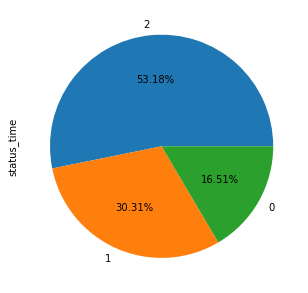

In [12]:
# display number of defaults
credit_surv.groupby("id").agg({"status_time":np.max})["status_time"].value_counts().plot.pie(autopct='%.2f%%', figsize=(5,8))

In [13]:
#keep defaulters in one category and combine the rest
credit_surv["status_time"] = credit_surv["status_time"].apply(lambda x: 1 if x == 1 else 0)


<AxesSubplot:ylabel='status_time'>

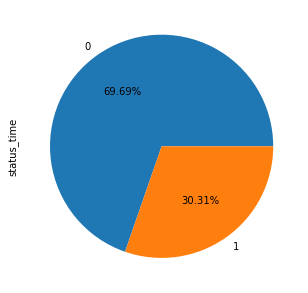

In [14]:
# display number of defaults
credit_surv.groupby("id").agg({"status_time":np.max})["status_time"].value_counts().plot.pie(autopct='%.2f%%', figsize=(5,8))

In [18]:
# convert episodic data to static
credit_static = credit_surv.groupby("id").agg(np.max).reset_index()

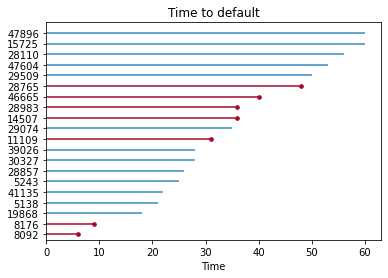

In [19]:
from lifelines.plotting import plot_lifetimes

df_samp = credit_static.sample(20)
ax = plot_lifetimes(df_samp["time"], event_observed=df_samp["status_time"])
ax.set_xlabel("Time")
ax.set_title("Time to default")
plt.show()

# Time to default for borrwers with low outstanding balance vs high

This section will evaluate whether the time to default for borrowers with low outstanding balance at origination time (30% quantile) significantly differs from borrowers with Average/High outstanding balance at origination time.
<br>
<br>
The Kaplan Meier estimator is used for this purpose. It is a non-parametric statistic used to estimate the survival function from lifetime data.
<br>
<br>
First, the cutoff for the 30th quantile was extracted to be able to create two groups based on the balance at origin time. Then the estimator was fit on both the sets and the survival function was plotted. Survival function computes the probability that a  specific applicant does **not** default at a specific time.
<br>
<br>
The plot first plot is the survival plot. It shows the survival probability.It shows that the low balance group has a stable survival probability as the drop is steadier as compared to the drop of the high balance group which can be considered less stable. Both the lines start to drop after time 25 and become constant after time 50. The intersection of the two lines around time 35 shows that after time 35 the low balance does not default (higher survival probability) as much as the high balance group. It is the other way around before time 35
<br>
<br>
To check if the difference between the two groups is statistically significant, the log rank test as performed. The null hypethosis states that there is no difference between the groups. The hypothesis was rejected at the 95% confidence level (p value lower than 0.05) and it was concluded that the two groups are different.

In [27]:
#define the value at the 30th quantile
cutoff = credit_static['balance_orig_time'].quantile(.3)
cutoff

127900.0

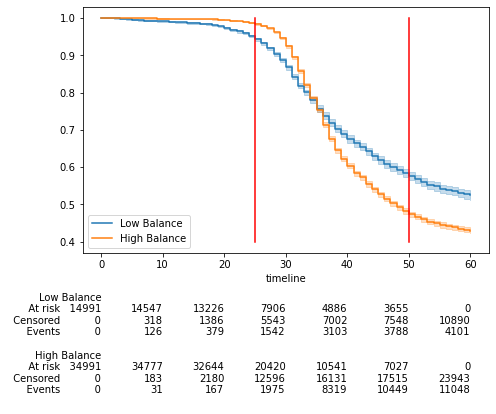

In [33]:
from lifelines import KaplanMeierFitter
# Compare two groups

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

fig, ax = plt.subplots(1,1 , figsize=(7,6))

# subset data
df1 = credit_static.loc[credit_static["balance_orig_time"] < cutoff,:]
df2 = credit_static.loc[credit_static["balance_orig_time"] >= cutoff,:]

# fit subset low balance
ax = kmf1.fit(df1['time'], df1['status_time'], label='Low Balance').plot_survival_function(ax=ax)

# fit subset high balance
ax = kmf2.fit(df2['time'], df2['status_time'], label='High Balance').plot_survival_function(ax=ax)

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf1, kmf2, ax=ax)
ax.plot([25, 25], [0.4,1], 'k-', c="red")
ax.plot([50, 50], [0.4,1], 'k-', c="red")
plt.tight_layout()

In [30]:
# Perform logrank test to assess whether there is a difference between low and high balance borrowers in time to default

from lifelines.statistics import logrank_test

# Null-Hypothesis: No difference between the two groups
res = logrank_test(df1['time'], df2['time'], event_observed_A=df1['status_time'],event_observed_B=df2['status_time'])

# We can reject the Null-Hypothesis (p < 0.05)
res.summary 

,test_statistic,p,-log2(p)
0,58.647544,1.886034e-14,45.591637


0.9435152621439395
0.5762923715465651


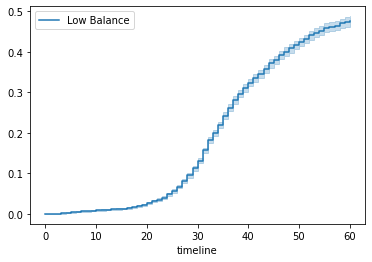

In [37]:
# plot cumulative function - Low balance group
kmf1.plot_cumulative_density()

print(kmf1.predict(25))
print(kmf1.predict(50))

0.984514372722241
0.47352947325557204


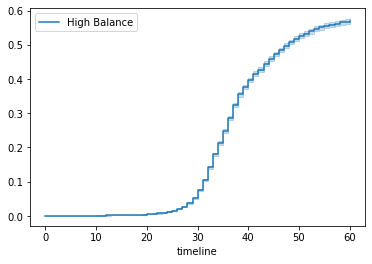

In [38]:
# plot cumulative function - High balance group
kmf2.plot_cumulative_density()

print(kmf2.predict(25))
print(kmf2.predict(50))

# Cox Proportional Hazard model (time varying)

The cox proportional hazard model was used to guage the impact of different economic variables on the probability to default. it works like a regression model and estimates the relationship between survival time and the covariates (economic variables in this case). This model computes the hazard function which is the the probability thatan applicant 𝑗 defaults at time 𝑖.
<br>
<br>
The first step was to selecte the prescribed variables. Then the Cox time varying fitter was fit on the data as there are some time varying variables in the selected variables as well. 
<br>
<br>
The p value for the relationship between each covariate and the probability to default was inspected. All the relationships are statisically significant. 
<br>
<br>
the size of the coefficients shows that the interest rate, gdp, and unemplyment rate have the biggest impact on the probability to default. The coefficients can be compared because of same scale of data.
<br>
<br>
The following shows the impact of the general economy on the probability of default.

- A unit increase in the housing price index reduces the probability to default by 0.777%

- A unit increase in the gdp growth rate reduces the probability to default by 8.161%

- A unit increase in the unemployment rate reduces the probability to default by 17.589%



In [41]:
# select the prescribed variables 
credit_tv = pd.merge(credit_surv[["default_time", "hpi_time", "gdp_time", "uer_time", "balance_time","interest_rate_time", "FICO_orig_time", "LTV_time", "id"]], credit_static[["id", "time"]]\
.rename(columns={"time":"time_end"}), on="id", how="inner") 

# Assumption: time always starts at 0 (no interval censored data)
credit_tv["first_time"] = 0

In [43]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(credit_tv, id_col="id", event_col="default_time", start_col="first_time", stop_col="time_end", show_progress=True)
ctv.summary

Iteration 9: norm_delta = 0.00000, step_size = 1.00000, ll = -193453.17044, newton_decrement = 0.00000, seconds_since_start = 87.8Convergence completed after 9 iterations.


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
hpi_time,-7.740875e-03,0.992289,6.880560e-04,-9.089441e-03,-6.392310e-03,0.990952,0.993628,0.0,-11.250356,2.306594e-29,95.130151
gdp_time,-7.844862e-02,0.924550,4.221043e-03,-8.672171e-02,-7.017552e-02,0.916932,0.932230,0.0,-18.585125,4.240095e-77,253.704367
uer_time,-1.620233e-01,0.850421,8.072698e-03,-1.778455e-01,-1.462011e-01,0.837072,0.863984,0.0,-20.070522,1.335949e-89,295.233735
balance_time,5.797074e-07,1.000001,2.129064e-08,5.379785e-07,6.214363e-07,1.000001,1.000001,0.0,27.228279,3.005373e-163,539.886736
interest_rate_time,1.718005e-01,1.187441,3.444280e-03,1.650498e-01,1.785511e-01,1.179452,1.195484,0.0,49.879945,0.000000e+00,inf
FICO_orig_time,-4.473182e-03,0.995537,1.211391e-04,-4.710611e-03,-4.235754e-03,0.995300,0.995773,0.0,-36.925990,1.769228e-298,989.111452
LTV_time,8.250427e-03,1.008285,1.351084e-04,7.985619e-03,8.515234e-03,1.008018,1.008552,0.0,61.065258,0.000000e+00,inf


In [44]:
# inspect p-values
ctv.summary['p']

covariate
hpi_time               2.306594e-29
gdp_time               4.240095e-77
uer_time               1.335949e-89
balance_time          3.005373e-163
interest_rate_time     0.000000e+00
FICO_orig_time        1.769228e-298
LTV_time               0.000000e+00
Name: p, dtype: float64

<AxesSubplot:xlabel='log(HR) (95% CI)'>

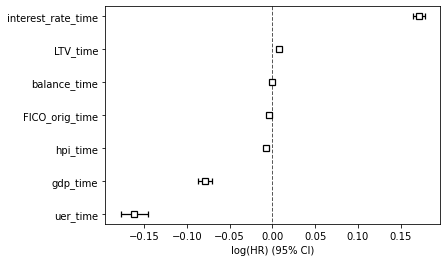

In [45]:
ctv.plot()

In [52]:
# print parameter values
print(round(ctv.params_, 6))

# Interpretation (under ceteris paribus assumption): 
print('\n A unit increase in the housing price index reduces the probability to default by {:.3f}%'.format((np.exp(0.007741) - 1)*100))
print('\n A unit increase in the gdp growth rate reduces the probability to default by {:.3f}%'.format((np.exp(0.078449) - 1)*100))
print('\n A unit increase in the unemployment rate reduces the probability to default by {:.3f}%'.format((np.exp(0.162023) - 1)*100))


covariate
hpi_time             -0.007741
gdp_time             -0.078449
uer_time             -0.162023
balance_time          0.000001
interest_rate_time    0.171800
FICO_orig_time       -0.004473
LTV_time              0.008250
dtype: float64

 A unit increase in the housing price index reduces the probability to default by 0.777%

 A unit increase in the gdp growth rate reduces the probability to default by 8.161%

 A unit increase in the unemployment rate reduces the probability to default by 17.589%


<AxesSubplot:>

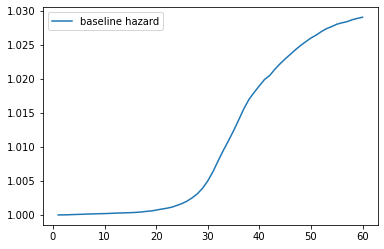

In [53]:
np.exp(ctv.baseline_cumulative_hazard_).plot()